# Actividad Integradora 2

## Analisis de sentimiento de tweets. 

Basado en los tutoriales de Sentdex: https://www.youtube.com/playlist?list=PLQVvvaa0QuDf2JswnfiGkliBInZnIC4HL 

Importamos las librerias que vamos a utilizar.

In [1]:
import nltk
import random
#from nltk.corpus import movie_reviews
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from nltk.tokenize import word_tokenize
from statistics import mode
from collections import Counter


[nltk_data] Downloading package punkt to /Users/Emi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Emi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Por alguna razon si se corre esto genera algun bug que baja el accuracy.

#Descubrimos el encoding de nuestro dataset.
#import chardet

#with open("positive.txt","rb") as rawdata:
#    result = chardet.detect(rawdata.read(100000))

#print(result)

#encod = result['encoding']

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [2]:
#Abrimos el archivo con los textos
short_pos = open("positive.txt","r",encoding = "Windows-1252").read()
short_neg = open("negative.txt","r",encoding = "Windows-1252").read()



In [3]:
all_words = []
documents = []

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]


for p in short_pos.split('\n'):
    documents.append( (p, "pos") ) #Adjuntamos la review a la lsita documents con su label en tuplas
    words = word_tokenize(p) # Se tokeniza la review
    pos = nltk.pos_tag(words) # Se identifica el tipo de palabra 
    for w in pos: #Se dejan solo el tipo de palabra permitido
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())


for p in short_neg.split('\n'):
    documents.append( (p, "neg") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [4]:
all_words = nltk.FreqDist(all_words)

all_words.most_common(15)

[('good', 369),
 ('more', 331),
 ('little', 265),
 ('funny', 245),
 ('much', 234),
 ('bad', 234),
 ('best', 208),
 ('new', 206),
 ('own', 185),
 ('many', 183),
 ('most', 167),
 ('other', 167),
 ('great', 160),
 ('big', 156),
 ('few', 139)]

#### Escribimos algunas funciones y clases utilizadas en los tutoriales.

In [5]:
word_features = list(all_words.keys())[:5000] #Agarramos las 5000 palabras mas comunes


#Convierte la lista de palabras a una lista de true y false dependiento si alguna de las 3000 palabras mas comunes 
# se encuentra en el review
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features


#Crea una lista de tuplas donde hay un diccionario donde las llaves son las 3000 palabras mas comunes y los valores son true
#o false dependiendo si se encuentra la palabra en el riview, el otro valor de la tubla es el label de neg o pos.
featuresets = [(find_features(rev), category) for (rev, category) in documents]

random.shuffle(featuresets)

In [7]:
#Clase para juntar todos los clasificadores.
class VoteClassifier(ClassifierI): #Inheritance from the ClassifierI class
    def __init__(self,*classifiers): #pass a list of classfiers
        self._classifiers = classifiers

    def find_mode(self,votes):# Se lo tuve que agregar porque ocurria un error cuando los dos valores tenian los mismos votos.
        c = Counter(votes)
        return (c.most_common(1))[0][0]
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return self.find_mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(self.find_mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [8]:
#Dividimos en train y test sets
testing_set = featuresets[10000:]
training_set = featuresets[:10000]

## Solo correr las siguientes DOS celdas si se quiere ver el entrenamiento de los modelos y como se guardan en pickle

In [9]:
# AVISO!!
# Si no se quiere ver como se entrenan los modelos no correr esta celda. Se pueden utilizar los pìckle ya guardados.
# Esta celda tarda varios minutos debido a que se estan entrenando los modelos 
# Aprox 

#El original de nltk
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

#Modelos de sklearn
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

#Tarda mucho en converger
#NuSVC_classifier = SklearnClassifier(NuSVC())
#NuSVC_classifier.train(training_set)
#print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


voted_classifier = VoteClassifier(classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)


Original Naive Bayes Algo accuracy percent: 71.6867469879518
Most Informative Features
              engrossing = True              pos : neg    =     21.0 : 1.0
                 generic = True              neg : pos    =     16.3 : 1.0
                mediocre = True              neg : pos    =     15.7 : 1.0
               inventive = True              pos : neg    =     15.0 : 1.0
                  boring = True              neg : pos    =     14.7 : 1.0
                    flat = True              neg : pos    =     14.6 : 1.0
                    warm = True              pos : neg    =     13.0 : 1.0
                    dull = True              neg : pos    =     12.6 : 1.0
             mesmerizing = True              pos : neg    =     11.0 : 1.0
                  stupid = True              neg : pos    =     11.0 : 1.0
               wonderful = True              pos : neg    =     11.0 : 1.0
                    chan = True              neg : pos    =     10.3 : 1.0
             

In [ ]:
"""
#Para los documentos

save_documents = open("documents.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()

#Para las word features

save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

#Para los classifiers

save_classifier = open("originalnaivebayes5k.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

save_classifier = open("MNB_classifier5k.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()

save_classifier = open("BernoulliNB_classifier5k.pickle","wb")
pickle.dump(BernoulliNB_classifier, save_classifier)
save_classifier.close()

save_classifier = open("LogisticRegression_classifier5k.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()

save_classifier = open("LinearSVC_classifier5k.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()
"""

## Utilizar la siguiente celda si se tienen los pickle en el mismo directorio que el notebook (LO mas conveniente)

In [10]:
## Es mejor utilizar los pickles para saltarse el procedimiento de entrenamiento.
## IMPORTANTE tener los pickles de los modelos en el mismo directorio que el notebook o cambiar el path
#Cargar los documentos 

documents_f = open("documents.pickle", "rb")
documents = pickle.load(documents_f)
documents_f.close()

#Cargar las word features

word_features5k_f = open("word_features5k.pickle", "rb")
word_features = pickle.load(word_features5k_f)
word_features5k_f.close()

#Cargar los classifiers

open_file = open("originalnaivebayes5k.pickle", "rb")
classifier = pickle.load(open_file)
open_file.close()


open_file = open("MNB_classifier5k.pickle", "rb")
MNB_classifier = pickle.load(open_file)
open_file.close()



open_file = open("BernoulliNB_classifier5k.pickle", "rb")
BernoulliNB_classifier = pickle.load(open_file)
open_file.close()


open_file = open("LogisticRegression_classifier5k.pickle", "rb")
LogisticRegression_classifier = pickle.load(open_file)
open_file.close()


open_file = open("LinearSVC_classifier5k.pickle", "rb")
LinearSVC_classifier = pickle.load(open_file)
open_file.close()

voted_classifier = VoteClassifier(classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)



In [11]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats),voted_classifier.confidence(feats)

### Twitter Live Sentiment Analysis 

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time
import json

%matplotlib inline

In [29]:
from tweepy import Stream
from tweepy import OAuthHandler
#import tweepy as tp
from tweepy.streaming import StreamListener


#consumer key, consumer secret, access token, access secret.
ckey="C0MsQRVLkMGGF4toOABEdxb7k"
csecret="miIUZX0JIj5UlIVQ5mj6h81RelQpe63kZA9YfjM04rwJd04eHM"
atoken="1019722469278736386-CtB43E6YXm2E8EB63IeSPGtlsKI3NI"
asecret="dydK5z0e5EYieS2IBvgZNPT0lTFRW3MQgXBRrKV4BpIk0"

class listener(StreamListener):
    def on_data(self, data):
        
        all_data = json.loads(data)
        
        tweet = all_data["text"]
        sentiment_value, confidence = sentiment(tweet)
        print(tweet, sentiment_value, confidence)
        
        if confidence*100 >= 80:
            output = open("twitter-out.txt","a")
            output.write(sentiment_value)
            output.write('\n')
            output.close()
            return True
            
    def on_error(self, status_code):
        print(status_code)
    

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)


twitterStream = Stream(auth, listener())
twitterStream.filter(track=["happy"], is_async=True)

time.sleep(20) #Especificamos el tiempo que queremos que corra en segundos

twitterStream.disconnect()


RT @KhoaPhan96: Mayhem in the duck city.
Happy 3rd anniversary dear Oozora Subaru the best duck. 
#大空スバル3周年 #大空スバル  #プロテインザスバル #しょこらーと #百鬼絵… pos 1.0
RT @Junieecorn: 210916 - yizhiyu/withfans fansign
#YEONJUN    #연준    

I built these lego flowers for Yeonjun as a birthday present and he… pos 0.6
@ab_zaddy I’m happy with my XR pos 1.0
@mrsrealismfan I bet it was a lot of work. Very happy for you. pos 1.0
RT @anthony_dion: Happy #WorldAfroDay. 🖤 https://t.co/VD5vAMKTBz neg 1.0
RT @lovincmila: y’all ain’t happy with ANYTHING, she’s one of the only female artist who is always supporting other female artists, this is… pos 1.0
RT @Ripudam16123726: Wish you a very happy birthday Sir
May Krishna bless you always and keep healthy. More power to you sir. 
We love you.… pos 0.8
RT @BamBam1A: Happy Birthday CYJ,Ars!🎉😂
@GOTYJ_Ars_Vita https://t.co/cjwaUXjAOE neg 1.0
@Classical_Ideas @Sacred_Writes I’m sure she’d be happy to set up an interview as well! Not sure I can get her to wear headphones thou

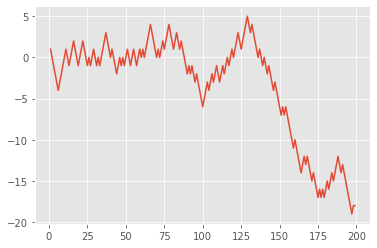

In [30]:
#Parte para graficar
style.use("ggplot")

#fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

pullData = open("twitter-out.txt","r").read()
lines = pullData.split('\n')

xar = []
yar = []

x = 0
y = 0

for l in lines:
    x += 1
    if l == "pos":
        y += 1
    elif l == "neg":
        y -= 1

    xar.append(x)
    yar.append(y)

plt.plot(xar,yar) 
plt.show()     
